# UMAP Plots for Outliers

 - **Author(s):** Mary B. Makarious
 - **Collaborators:** Cornelis Blauwendraat and Mike Nalls 
 - **Date Notebook Created:** 09.08.2019
    - **Quick Description:** Adding Z-score for age, removing PCs prior to UMAP, keeping running to TODO list...

---
### Quick Description: 
#### Problem:
Outliers in data cause issues downstream with most analyses. We need to find some way to take those out.

#### Solution:
By taking in a modified covariate file, we can preprocess the data in a way that only has numbers that can feed into an algorithm. 
Following preprocessing, we can reduce the data and identify outliers using UMAP.
Because this data has confirmed GBA carrier status of yes/no, we can run a logistic regression to see if UMAP vectors are associated with GBA carrier status.

### Motivation/Background:
**What is an Isolation Forest Analysis?:** 
Explicitly identifies anomalies instead of profiling normal data points, and is based on decision trees.

Each observation is given an anomaly score and the following decision can be made on its basis:
- Score close to 1 indicates anomalies
- Score much smaller than 0.5 indicates normal observations
- If all scores are close to 0.5 than the entire sample does not seem to have clearly distinct anomalies

**Properties of Logistic Regression:**
- The dependent variable in logistic regression follows Bernoulli Distribution
- Estimation is done through maximum likelihood
- No R Square, Model fitness is calculated through Concordance, KS-Statistics
- **Binary Logistic Regression:** The target variable has only two possible outcomes (ex. YES GBA or NO GBA) 
- We actually have a column that has the GBA carrier status, so we are just going to come up with how accurate LR would be in predicting this following UMAP reduction.

### Concerns/Impact on Related Code:
- Currently, this notebook has no defined functions
- In the future, could likely remove the step on imputation since Mike has that in his pruning notebook

### Thoughts for Future Development of Code in this Notebook:
- Added functionality?

---
## Proposed Workflow

#### [0. Getting Started](#0)
This includes:
1. Installing and importing the necessary packages for this script
2. Reading in the dataset files and initializing some reusable variables 

#### [1. Prepping the Data](#1)
The includes:
1. After reading in the data, the FID and IID columns need to be dropped 
2. The cohorts are in the column `DATASET`, but are written as strings
    - These will need to be one-hot encoded, or expanded into columns and having 1=True and 0=False 
3. Dealing with missingness 
    - The preferred method here would be to impute the missingness values, and not straight up remove them
4. Generating Z-scores for age
    - Preferred, since this can be later compared to other Z-scores from different normal distributions

#### [2. Clustering and Generating UMAP Vectors](#2)
This includes:
1. After cleaning and prepping the data, run the IsolationForest model to detect outliers
2. Reduction of features using UMAP to 2D 

#### [3. Logistic Regression of UMAP Vectors vs. Carrier Status](#3)
This includes: 
1. Calculating a simple logistic regression to look at vectors vs. GBA carrier status
2. Calculating and visualizing a confusion matrix 
3. Calculating and visualizing an ROC 

### TODO:
- <input type="checkbox" checked> Add 3 sentences with problem and solution at the top 
- <input type="checkbox" checked> Remove PC 1-10 from original csv 
- <input type="checkbox" checked> Remove GBA before UMAP
- <input type="checkbox" checked> Following imputation of age, generate a Z-score in a separate column (drop the original AGE column)
- <input type="checkbox" checked> Remove Confusion Matrix + ROC curve
- <input type="checkbox"> Look into feature weights for each of the variables (?)
- <input type="checkbox"> Regression based on just the vectors out of a UMAP?
- <input type="checkbox"> Add...???


 

--- 
<a id="Getting-Started"></a>
## 0. Getting Started

To get started, we will be importing the necessary packages and reading in the file

In [0]:
## Import the necessary packages 

# General 
import os
import argparse
import sys
import pandas as pd
import numpy as np
import time

# For visualization
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline

# For Z-Score Generation
from sklearn import preprocessing
import scipy.stats as stats

# For preprocessing
from sklearn.impute import SimpleImputer

# For Isolation Forest
import xgboost
import sklearn
from sklearn.ensemble import IsolationForest

# For UMAP reduction and plotting
import umap.umap_ as umap

# For saving out UMAP for later
from joblib import dump, load

# For logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# For creating the confusion matrix 
from sklearn import metrics

# If not installed already, uncomment this to directly install it to your environment 
    # xgboost and umap(-learn) aren't native to the conda environment but need to be downloaded for this 
    
#!pip install xgboost
#!pip install umap-learn

In [0]:
# GOOGLE COLAB SPECIFIC - Upload the file once 
#from google.colab import files
#uploaded = files.upload()

In [0]:
# GOOGLE COLAB SPECIFIC - Reading in an uploaded csv
import io
input_data = pd.read_csv(io.BytesIO(uploaded["mergedN370S.csv"]), engine="c", sep=",", index_col = None)

# Start logging time 
start_time = time.time()

# Generate IDs 
IDs = input_data['FID']

# Creating prefix for all things made and exported after 
prefix = "mergedN370S"

---
<a id="1"></a>
## 1. Prepping the Data
The data when read as a `pandas` dataframe have a mix of datatypes -- which is going to be a pain for the clustering algorithm to train and test on. 

#### Steps: 
 1. To remove the FID and IID columns (these are not necessary)
     - For now, AGE will also be removed (until we work on imputation)
 2. To convert any values that are infinite to NaN
 3. To typecase the dataframe into type float to be read into the algorithms 
 4. To one-hot encode the different cohorts
 5. To impute to deal with missingness (focus on age, then others)
     - Calculate the amount of missingness
     - Look into univariate imputation: https://scikit-learn.org/stable/modules/impute.html
 
The first 2 columns in the datasets are FID and IID, both with letters in them. These were removed.

In [0]:
# Dropping the FID, IID, IID2 columns
# Replace any infinite values found in the dataset with NaN (to be removed later)
numerical_data = input_data.drop(columns=['FID','IID','IID2']).replace([np.inf, -np.inf], np.nan)

# Typecast to floats 
numerical_data_float = numerical_data.astype(float, copy=True, errors='ignore')

# Peek at the data
numerical_data_float.head()

,fatid,matid,sex,PHENO_PLINK,SEX_COV,PHENO,AGE,DATASET,GBA
0,0.0,0.0,1.0,1.0,0.0,0.0,78.0,NEUROX_DBGAP,1.0
1,0.0,0.0,2.0,1.0,1.0,0.0,81.0,NEUROX_DBGAP,1.0
2,0.0,0.0,2.0,1.0,1.0,0.0,80.0,NEUROX_DBGAP,1.0
3,0.0,0.0,2.0,1.0,1.0,0.0,90.0,NEUROX_DBGAP,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,78.0,NEUROX_DBGAP,1.0


### Impute Missing Ages

In [0]:
# Impute to deal with missingness
    # Deal with age first

# See how much missigness in age you have first
#age_missingness = df.isnull().sum()/len(df)*100
#print(age_missingness)
    # Looks like AGE has 16% missingness -- this should be fine to impute
    # Mike tends to impute for things that have ~15% missingness
    
# Specify how you will impute -- using mean here because it's simple
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
numerical_data_float["AGE"] = imp.fit_transform(numerical_data_float[["AGE"]]).ravel()

# After imputing age, remove rows that still have NaN values in the rows 

# Check where the NaN values are
#np.where(np.isnan(numerical_data_float))

# Remove NaN if necessary 
#numerical_data_float.dropna()

### Calculate Z-score for Age

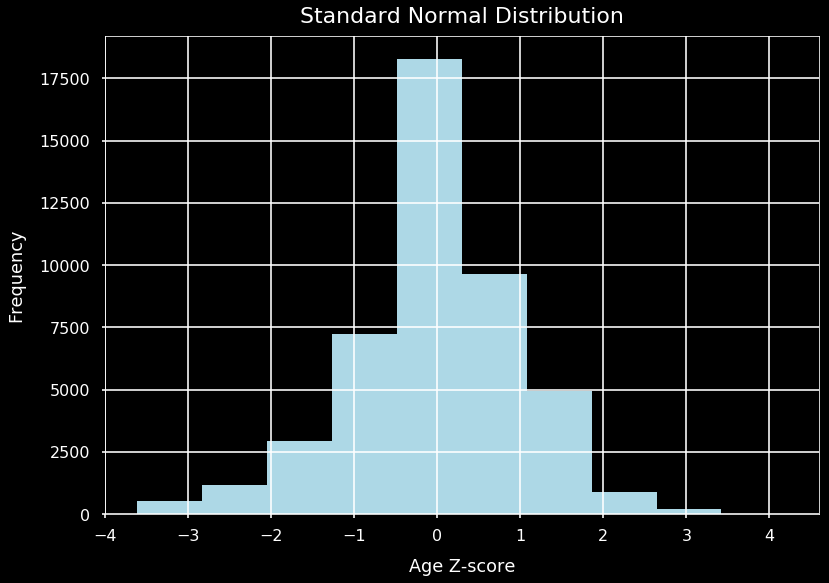

In [0]:
# Calculate the age mean 
age_mean = numerical_data_float['AGE'].mean()

# Calculate the standard deviation 
age_std_dev = numerical_data_float['AGE'].std()

# Calculate the Z-score 
numerical_data_float['AGE_ZScore'] = (numerical_data_float['AGE']-age_mean)/age_std_dev

# Visualize 
style.use('seaborn-poster')
style.use('dark_background')
sns.set_style({'axes.grid': False})

numerical_data_float['AGE_ZScore'].hist(color='lightblue')
plt.title("Standard Normal Distribution", y=1.015, fontsize=22)
plt.xlabel("Age Z-score", labelpad=14)
plt.ylabel("Frequency", labelpad=14);

### One-Hot Encode the Cohort Column

In [0]:
#  One-hot encode the cohorts
encoding_df = pd.get_dummies(numerical_data_float['DATASET'], prefix = 'COHORT', dtype=float)

# Merge the encoded cohorts with the actual dataset
    # Dropping "DATASET" in original df so we don't keep a whole column of strings
    # Dropping "AGE" so that the age Z-scores can be used
df_encoded = pd.concat([numerical_data_float, encoding_df], axis=1).drop(columns=['DATASET', 'AGE'])

# Typecase 
df_encoded.astype(float, copy=True, errors='ignore')

# Drop any remaining NaNs
df_encoded.dropna(inplace=True)

# Save out the data to another df to keep the GBA status to merge later
df_GBA = df_encoded.copy(deep=True)

# Remove the GBA status from the original df prior to UMAP
df_encoded.drop(columns=['GBA'])
df_encoded.head()

,fatid,matid,sex,PHENO_PLINK,SEX_COV,PHENO,GBA,AGE_ZScore,COHORT_DUTCH,COHORT_FINLAND,COHORT_GERMANY,COHORT_HBS,COHORT_MCGILL,COHORT_MF,COHORT_NEUROX_DBGAP,COHORT_NIA,COHORT_OSLO,COHORT_PDBP,COHORT_PPMI,COHORT_PROBAND,COHORT_PROPARK,COHORT_SHULMAN,COHORT_SPAIN3,COHORT_SPAIN4,COHORT_TUBI,COHORT_UK_GWAS,COHORT_VANCE
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.273514,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,1.0,1.0,0.0,1.0,1.517747,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,1.0,1.0,0.0,1.0,1.436336,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.250444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.273514,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
<a id="2"></a>
## 2. Clustering and Generating UMAP Vectors

**What's Happening? :** 
These next steps will run an isolation forest analysis to identify possible outliers

**What is an Isolation Forest Analysis? :** 
Explicitly identifies anomalies instead of profiling normal data points, and is based on decision trees.

Each observation is given an anomaly score and the following decision can be made on its basis:
 - Score close to 1 indicates anomalies
 - Score much smaller than 0.5 indicates normal observations
 - If all scores are close to 0.5 than the entire sample does not seem to have clearly distinct anomalies
 
**How does it Work? :** The IsolationForest "isolates" observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature

### Isolation Forest to Identify Anomalies

In [0]:
## Here is where the clustering begins for real now that the prep is done.

print("Running an isolation forest analysis to identify possible outliers, this method is used to detect outliers in high dimensional data, like how your bank flags possible credit card fraud...")
print("")

### We generally run isolation forest and umap.

IsolationForest_outlier_detection = IsolationForest(behaviour='new', random_state=1, contamination='auto', n_jobs=-1, max_samples=100, n_estimators=100)
IsolationForest_outlier_detection.fit(df_encoded)
IsolationForest_outliers_predicted = IsolationForest_outlier_detection.predict(df_encoded)

IsolationForest_outliers_predicted_df = pd.DataFrame(IsolationForest_outliers_predicted)
IDs_df = pd.DataFrame(IDs)

Running an isolation forest analysis to identify possible outliers, this method is used to detect outliers in high dimensional data, like how your bank flags possible credit card fraud...



In [0]:
### Check the rank and assess the sparsity of the matrix

# See the rank of the matrix 
np.linalg.matrix_rank(df_encoded)
    # Not sparse! Moving forward

24

### UMAP Reduction + Visualization

... also making a quick UMAP run to reduce all your data to a 2 dimensional space for display purposes...



/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 483 separate connected components using meta-embedding (experimental)
  n_components


... your analysis just finished.

We exported a file called mergedN370S.outlier_detection_results.csv that contains a list of samples in this analysis annotated as either a likely inlier to be kept in the analysis (STATUS == in) or a possible outlier that you may want to consider excluding (STATUS == out). It also contains the UMAP embeddings from the plot.
Your data is summarized in the figure saved as mergedN370S.umap_plot.png showing UMAP embeddings with color-coded outliers (blue) versus inliers (purple).



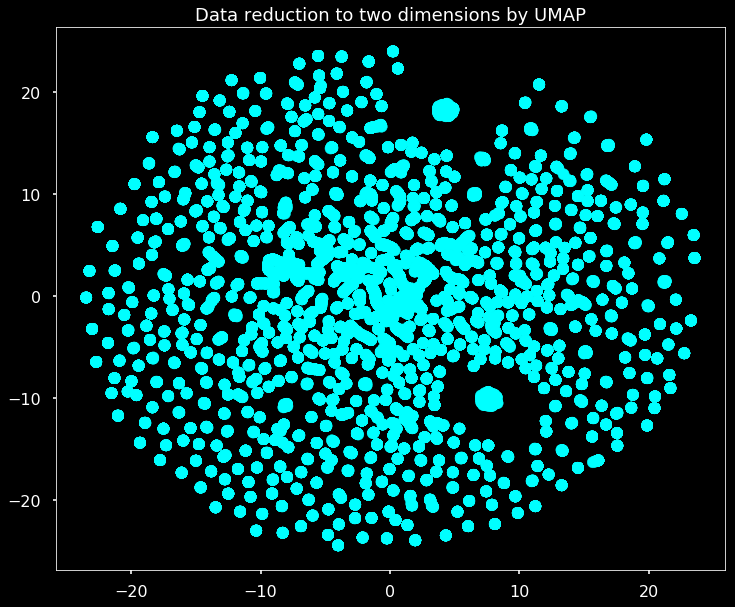

In [0]:
## UMAP
print("... also making a quick UMAP run to reduce all your data to a 2 dimensional space for display purposes...")
print("")

# Reduce the number of features
#reducer = umap.UMAP(random_state=42)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_encoded)

embedding1 = pd.DataFrame(embedding[:, 0])
embedding2 = pd.DataFrame(embedding[:, 1])

out_data = pd.concat([IDs_df.reset_index(), IsolationForest_outliers_predicted_df.reset_index(drop=True), embedding1.reset_index(drop=True), embedding2.reset_index(drop=True)], axis = 1, ignore_index=True)
out_data.columns=['INDEX','ID',"STATUS", "UMAP_embedding1", "UMAP_embedding2"]
out_data = out_data.drop(columns=['INDEX'])

# Plot the actual UMAP
fig, ax = plt.subplots(figsize=(12, 10))
color = out_data.STATUS.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="cool")
plt.title("Data reduction to two dimensions by UMAP", fontsize=18)
plot_out = prefix + '.umap_plot.png'
plt.savefig(plot_out, dpi=600)

out_data['STATUS'].replace([-1,1],['out','in'],inplace=True)

out_file = prefix + '.outlier_detection_results.csv'
out_data.to_csv(out_file, index=False)

print("... your analysis just finished.")
print("")
print("We exported a file called", out_file, "that contains a list of samples in this analysis annotated as either a likely inlier to be kept in the analysis (STATUS == in) or a possible outlier that you may want to consider excluding (STATUS == out). It also contains the UMAP embeddings from the plot.")
print("Your data is summarized in the figure saved as", plot_out, "showing UMAP embeddings with color-coded outliers (blue) versus inliers (purple).")
print("")

### Save UMAP to .joblib for Future Use

In [0]:
### Also save off the clusters for use later using joblib

exported_reducer = reducer.fit(df_encoded) 
algo_out = prefix + '.umap_clusters.joblib'
dump(exported_reducer, algo_out)

print("The clusters have been saved as", algo_out, "for later use and can be found in your working directory.")
print("You can now use these clusters to compare how any new data might look compared to the current dataset.")
print()

### Finish logging time.

end_time = time.time()
elapsed_time = (end_time - start_time)
print("Runtime in seconds: {:.4}".format(elapsed_time))
print("")

### Send them a summary and a nice message

ins = out_data[out_data.STATUS == "in"]
outs = out_data[out_data.STATUS == "out"]

count_ins = ins.shape[0]
count_outs = outs.shape[0]

print("You detected", count_outs, "possible outliers in you data, might be good to remove these before training models.")
print(count_ins, "were not flagged as outliers and probably good to go for analysis.")
print("If the percent of outliers is more than 10% of the total sample size, we'd suggest taking another look at your data and probably doing some recleaning.")
print("Although, if you have a higher than expected rate of outliers and the data is just a single cluster in the UMAP plot, you are probably alright.")
print()

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 483 separate connected components using meta-embedding (experimental)
  n_components


The clusters have been saved as mergedN370S.umap_clusters.joblib for later use and can be found in your working directory.
You can now use these clusters to compare how any new data might look compared to the current dataset.

Runtime in seconds: 564.9

You detected 0 possible outliers in you data, might be good to remove these before training models.
45866 were not flagged as outliers and probably good to go for analysis.
If the percent of outliers is more than 10% of the total sample size, we'd suggest taking another look at your data and probably doing some recleaning.
Although, if you have a higher than expected rate of outliers and the data is just a single cluster in the UMAP plot, you are probably alright.



In [0]:
# We can glance at the outliers
print(outs)
print("")

# We can also just print out the IDs
print(outs['ID'])

Empty DataFrame
Columns: [ID, STATUS, UMAP_embedding1, UMAP_embedding2]
Index: []

Series([], Name: ID, dtype: object)


---
<a id="3"></a>
## 3. Logistic Regression of UMAP Vectors vs. Carrier Status

Goal here is to preform a simple logistic regression on the output of UMAP vectors to the GBA carrier status. Since the column is broken into 1s and 2s -- we will be dealing with a binary logistic regression 

#### Properties of Logistic Regression:
 - The dependent variable in logistic regression follows Bernoulli Distribution
 - Estimation is done through maximum likelihood
 - No R Square, Model fitness is calculated through Concordance, KS-Statistics

#### Types of Logistic Regression:
 - **Binary Logistic Regression:** The target variable has only two possible outcomes (ex. YES GBA or NO GBA) 
 - **Multinomial Logistic Regression:** The target variable has three or more nominal categories (ex. Categories with nouns as names, not numerical)
 - **Ordinal Logistic Regression:** The target variable has three or more ordinal categories (ex. Categories rated by 1 thru 5)

#### Notes:
We actually have a column that has the GBA carrier status, so we are just going to come up with how accurate LR would be in predicting this following UMAP reduction.

Looking at the dataset, it looks as though people are classified with a `1` or `2` in the GBA column
 - We can likely assume 1=Non-carrier while 2=carrier, though 



In [0]:
# Print out the dataframe that went into UMAP and the associated GBA cases just so we can see them
print(df_temp[['FID','GBA']])

# We can even try to see one of the patients what their GBA status is 
print("")
print("See what a particular patient's GBA status is")
print(df_temp.loc[df_temp['FID'] == 'BCN1_CO_0148_BCN1_CO_0148'][['FID','GBA']])

                           FID  GBA
0                      00_1001    1
1                      00_1050    1
2                      00_1093    1
3                      00_1142    1
4                      00_1187    1
5                       001_10    1
6                       002_08    1
7                       003_08    1
8                       003_10    1
9                       004_06    1
10                      005_09    1
11                      006_09    1
12                      006_10    1
13                      007_06    1
14                      007_08    1
15                      007_09    1
16                      008_10    1
17                      009_09    1
18                      01_083    1
19                      010_09    1
20                      011_09    1
21                      011_10    1
22                      011_11    1
23                      012_08    1
24                      013_09    1
25                      013_10    1
26                      013_

In [0]:
#Merge the UMAP vectors to the file and keep only the count_ins (thereby excluding the outliers)

# Rename the ID column in the "ins" df to FID to merge later
ins.rename(columns={"ID": "FID"}, inplace = True)
#ins.head()

# Get the df that went into the IsolationForest and glue the IDs back to left-join with no outliers later 
#print("Dataframe that went into IsolationForest and UMAP (one-hot encoded and imputed): ", df.shape)
#print("IDs from original dataset shape: ", IDs.shape)

# Add the IDs so we know what to remove 
df_IDs = pd.concat([IDs, df_GBA], axis=1, ignore_index=False)


df_IDs.head()

,FID,fatid,matid,sex,PHENO_PLINK,SEX_COV,PHENO,GBA,AGE_ZScore,COHORT_DUTCH,COHORT_FINLAND,COHORT_GERMANY,COHORT_HBS,COHORT_MCGILL,COHORT_MF,COHORT_NEUROX_DBGAP,COHORT_NIA,COHORT_OSLO,COHORT_PDBP,COHORT_PPMI,COHORT_PROBAND,COHORT_PROPARK,COHORT_SHULMAN,COHORT_SPAIN3,COHORT_SPAIN4,COHORT_TUBI,COHORT_UK_GWAS,COHORT_VANCE
0,00_1001,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.273514,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00_1050,0.0,0.0,2.0,1.0,1.0,0.0,1.0,1.517747,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00_1093,0.0,0.0,2.0,1.0,1.0,0.0,1.0,1.436336,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00_1142,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.250444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00_1187,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.273514,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Merge the datasets to remove the outliers
no_outliers2 = pd.merge(ins, df_IDs, on = "FID", how = "left")

# Keep the IDs from the dataset with no outliers for later 
IDs_no_outliers = df_IDs['FID']

# Cast everything to a float 
# Drop the "STATUS" column residual from the UMAP reduction 
# Also drop the "FID" column 
no_outliers = no_outliers2.astype(float, copy=True, errors='ignore').drop(columns=['FID','STATUS'])

# List the column names
list(no_outliers)

# See the outputs available for GBA 
#no_outliers.GBA.value_counts()
    # Only available options are 1 and 2

no_outliers.GBA.value_counts()

1.0    45544
2.0      322
Name: GBA, dtype: int64

### Selecting Features
Need to divide the given columns into two types of variables:
1. **Dependent** (or target variable) 
2. **Independent** (or feature variables)

In [0]:
# Split dataset in features and target variable

feature_cols = no_outliers.loc[:, no_outliers.columns != "GBA"]
X = no_outliers[feature_cols.columns.values] # Features
y = no_outliers.GBA # Target variable 

### Splitting the Data

Divide the dataset into:
1. **Training** 
2. **Testing** 

We will be using `scikitlearn` for this, and the df will be broken into 2 parts in a ratio of 75 (training) : 25 (testing)

In [0]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Create the model (using the default parameters)
log_reg = LogisticRegression(solver='liblinear')

# Fit the model on the training set
log_reg.fit(X_train, y_train)

# Perform prediction on the testing set
y_pred = log_reg.predict(X_test)